In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import warnings
import scipy.io as scio
import matlab.engine
import torch
from net import PhyCNN, PhyRNN
warnings.filterwarnings("ignore")
sns.set_style('ticks')
# sns.set()
sns.set_context("poster")
plt.rcParams['font.sans-serif'] = 'Times New Roman'
matlabeng = matlab.engine.start_matlab()   #启动matlab

## 加载mat格式结果数据

In [3]:
station = 'IBRH13'
net = 'CNN'
motiontype = 'record'
filedir = os.path.join(station + '_results', motiontype + '_' + net)
data = scio.loadmat(os.path.join(filedir, 'result.mat'))
data_md = scio.loadmat(os.path.join(station + '_results', 'simulate_CNN', 'result.mat'))
msg = pd.read_excel(os.path.join(station + '_data', 'message.xlsx'))
msg = msg.sort_values('Record code')

In [ ]:
i = 21
dt = float(data['dt'][0, 0])
Period = np.logspace(-2, 1, 101)
ttime = data['time'].ravel()

down = data['test_data'][i, :, 0]
label = data['test_label'][i, :, 0]
pred = data['test_pred'][i, :, 0]
simu = data_md['test_label'][i, :, 0]
rps_up = matlabeng.getResponseSpectrum(matlab.double(label.tolist()), dt)
rps_up = np.array(rps_up).ravel() / np.max(np.abs(label))
rps_pd = matlabeng.getResponseSpectrum(matlab.double(pred.tolist()), dt)
rps_pd = np.array(rps_pd).ravel() / np.max(np.abs(pred))
rps_md = matlabeng.getResponseSpectrum(matlab.double(simu.tolist()), dt)
rps_md = np.array(rps_md).ravel() / np.max(np.abs(simu))

plt.figure(figsize=(8, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
ax1 = plt.subplot2grid((3, 1), (0, 0))
ax1.plot(ttime, label, 'b', linewidth=1, label='Label')
ax1.plot(ttime, pred, 'r', linewidth=1, label='Prediction')
# ax1.plot(ttime, simu, 'b--', linewidth=1, label='Simulated')
# ax1.plot(ttime, 5*down, 'k--', linewidth=1)
plt.xlim([15, 35]), plt.ylim([-22, 22])
ylim = max(np.max(np.abs(label)), np.max(np.abs(pred)))
plt.ylim([-1.1 * ylim, 1.1 * ylim])
plt.xlabel('t (s)'), plt.ylabel('acc (gal)')

ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)
ax2.semilogx(Period, rps_up, 'b', linewidth=2, label='Label')
ax2.semilogx(Period, rps_pd, 'r', linewidth=2, label='Prediction')
# ax2.semilogx(Period, rps_md, 'b--', linewidth=2, label='Simulated')
plt.xlim([0.01, 20]), plt.ylim([0, 4.2])
plt.xlabel('Period (s)'), plt.ylabel('$\\beta$'), plt.legend(loc='upper right')
plt.savefig(os.path.join(filedir, 'test%d.svg' % i), bbox_inches='tight')

## 绘制loss变化曲线

In [ ]:
train_loss = data['train_loss'].ravel()
valid_loss = data['valid_loss'].ravel()
maxEpoch = len(train_loss)
maxEpoch = 1000
maxLoss = 1.1 * float(max(max(train_loss), max(valid_loss)))
minLoss = max(0, 0.9 * float(min(min(train_loss), min(valid_loss))))

plt.figure(figsize=(7, 5))
plt.plot(range(1, 1 + maxEpoch), train_loss[:maxEpoch], label='train', marker='o', markevery=int(maxEpoch / 10))
plt.plot(range(1, 1 + maxEpoch), valid_loss[:maxEpoch], label='valid', marker='s', markevery=int(maxEpoch / 10))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.25, 0.82])
plt.legend(loc='upper right')
# plt.xticks(range(0, maxEpoch + 1, int(maxEpoch / 5)))
# plt.axis([0, maxEpoch, minLoss, maxLoss])
# plt.yscale('log')
plt.savefig(os.path.join(filedir, 'loss.svg'), bbox_inches='tight')

## 计算并绘制误差和相关系数分布图

In [4]:
train_data = data['train_data'][:, :, 0]
test_data = data['test_data'][:, :, 0]
train_label = data['train_label'][:, :, 0]
train_pred = data['train_pred'][:, :, 0]
test_label = data['test_label'][:, :, 0]
test_pred = data['test_pred'][:, :, 0]
PGA_train = np.max(np.abs(train_label), axis=1)
PGA_test = np.max(np.abs(test_label), axis=1)
err_train = np.mean(((train_pred - train_label) / PGA_train[:, None])**2, axis=1)
err_test = np.mean(((test_pred - test_label) / PGA_test[:, None])**2, axis=1)
r_train = np.zeros_like(err_train)
r_test = np.zeros_like(err_test)
for i in range(len(r_train)):
    r_train[i] = np.corrcoef(train_label[i, :], train_pred[i, :])[0, 1]
for i in range(len(r_test)):
    r_test[i] = np.corrcoef(test_label[i, :], test_pred[i, :])[0, 1]

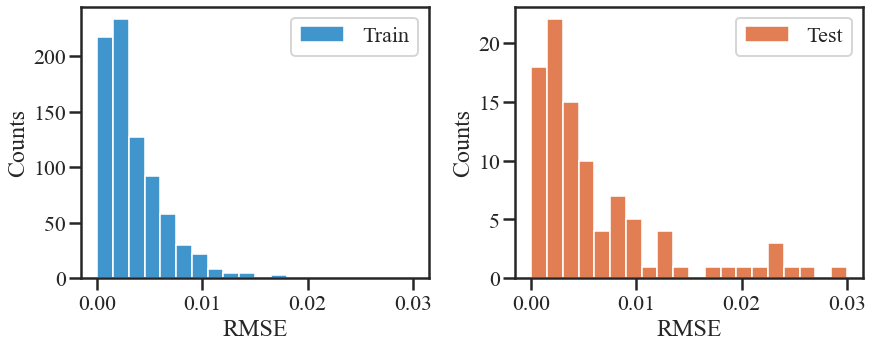

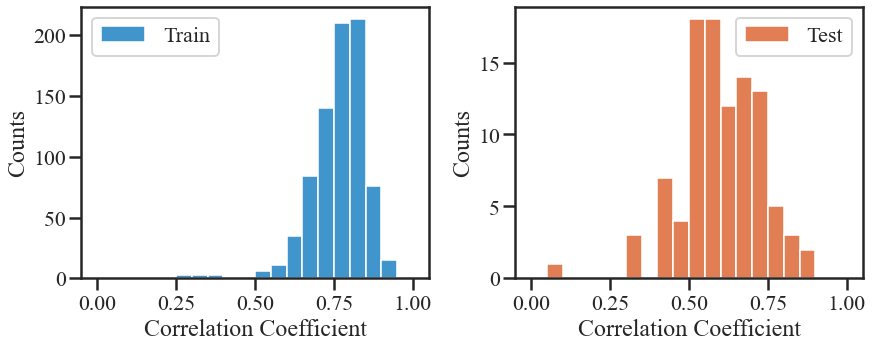

In [5]:
plt.figure(figsize=(14, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)

plt.subplot(1, 2, 1)
sns.histplot(err_train, bins=20, binrange=[0, 0.03], color='#0072BD', label='Train')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(err_test, bins=20, binrange=[0, 0.03], color='#D95319', label='Test')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
plt.savefig(os.path.join(filedir, 'RMSE.svg'), bbox_inches='tight')

plt.figure(figsize=(14, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)

plt.subplot(1, 2, 1)
sns.histplot(r_train, bins=20, binrange=[0, 1], color='#0072BD', label='Train')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.savefig(os.path.join(filedir, 'r_train.svg'), bbox_inches='tight')

plt.subplot(1, 2, 2)
sns.histplot(r_test, bins=20, binrange=[0, 1], color='#D95319', label='Test')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.savefig(os.path.join(filedir, 'corrcoef.svg'), bbox_inches='tight')

## 绘制误差和相关系数随PGA的变化图

In [ ]:
plt.figure(figsize=(14, 5))
# plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.subplot(1, 2, 1)
sns.scatterplot(PGA_train, r_train, marker='o', color='#0072BD', label='Train')
sns.scatterplot(PGA_test, r_test, marker='s', color='#D95319', label='Test')
plt.xscale('log')
plt.xlim([1, 1000])
plt.ylim([0, 1])
plt.xlabel('PGA (gal)')
plt.ylabel('Correlation coefficient')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.legend(loc='lower left')
plt.subplot(1, 2, 2)
sns.scatterplot(PGA_train, err_train, marker='o', color='#0072BD', label='Train')
sns.scatterplot(PGA_test, err_test, marker='s', color='#D95319', label='Test')
plt.xscale('log')
plt.xlim([1, 1000])
plt.ylim([-0.002, 0.04])
plt.xlabel('PGA (gal)')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.savefig(os.path.join(filedir, 'MSE_Corrcoef_PGA.svg'), bbox_inches='tight')

## 绘制误差和相关系数随其他地震特征量的变化图

从信息表格中提取震源深度、震级和震中距等地震动信息

In [ ]:
evenlist = np.loadtxt(os.path.join(station + '_results', 'selectevent.txt'), dtype=str)
idx_train = data['train_idx'][0, :]
idx_test = data['test_idx'][0, :]
msg_train = np.zeros((len(PGA_train), 3))
msg_test = np.zeros((len(PGA_test), 3))
for i in range(msg_train.shape[0]):
    msg_train[i, 0] = float(msg[msg['Record code'] == evenlist[idx_train[i]]]['Depth (km)'])
    msg_train[i, 1] = float(msg[msg['Record code'] == evenlist[idx_train[i]]]['Magnitude'])
    msg_train[i, 2] = float(msg[msg['Record code'] == evenlist[idx_train[i]]]['Epicentral distance (km)'])
for i in range(msg_test.shape[0]):
    msg_test[i, 0] = float(msg[msg['Record code'] == evenlist[idx_test[i]]]['Depth (km)'])
    msg_test[i, 1] = float(msg[msg['Record code'] == evenlist[idx_test[i]]]['Magnitude'])
    msg_test[i, 2] = float(msg[msg['Record code'] == evenlist[idx_test[i]]]['Epicentral distance (km)'])    

绘制误差和相关系数随震级的分布图

In [ ]:
plt.figure(figsize=(14, 5))
# plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.subplot(1, 2, 1)
sns.scatterplot(msg_train[:, 1], r_train, marker='o', color='#0072BD', label='Train')
sns.scatterplot(msg_test[:, 1], r_test, marker='s', color='#D95319', label='Test')
plt.xlim([3, 8.5])
plt.xticks(np.arange(3, 9, 1))
plt.ylim([0, 1])
plt.xlabel('Magnitude')
plt.ylabel('Correlation coefficient')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.legend(loc='lower left')
plt.subplot(1, 2, 2)
sns.scatterplot(msg_train[:, 1], err_train, marker='o', color='#0072BD', label='Train')
sns.scatterplot(msg_test[:, 1], err_test, marker='s', color='#D95319', label='Test')
plt.xlim([3, 8.5])
plt.xticks(np.arange(3, 9, 1))
plt.ylim([-0.002, 0.04])
plt.xlabel('Magnitude')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.savefig(os.path.join(filedir, 'MSE_Corrcoef_Mw.svg'), bbox_inches='tight')

绘制误差和相关系数随震源深度的分布图

In [ ]:
plt.figure(figsize=(14, 5))
# plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.subplot(1, 2, 1)
sns.scatterplot(msg_train[:, 0], r_train, marker='o', color='#0072BD', label='Train')
sns.scatterplot(msg_test[:, 0], r_test, marker='s', color='#D95319', label='Test')
plt.xlim([0, 200])
plt.xticks(np.arange(0, 250, 50))
plt.ylim([0, 1])
plt.xlabel('Depth (km)')
plt.ylabel('Correlation coefficient')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
sns.scatterplot(msg_train[:, 0], err_train, marker='o', color='#0072BD', label='Train')
sns.scatterplot(msg_test[:, 0], err_test, marker='s', color='#D95319', label='Test')
plt.xlim([0, 200])
plt.xticks(np.arange(0, 250, 50))
plt.ylim([-0.002, 0.04])
plt.xlabel('Depth (km)')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.savefig(os.path.join(filedir, 'MSE_Corrcoef_Depth.svg'), bbox_inches='tight')

绘制误差和相关系数随震中距的分布图

In [ ]:
plt.figure(figsize=(14, 5))
# plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.subplot(1, 2, 1)
sns.scatterplot(msg_train[:, 2], r_train, marker='o', color='#0072BD', label='Train')
sns.scatterplot(msg_test[:, 2], r_test, marker='s', color='#D95319', label='Test')
plt.xlim([0, 300])
plt.xticks(np.arange(0, 350, 100))
plt.ylim([0, 1])
plt.xlabel('Epicentral distance (km)')
plt.ylabel('Correlation coefficient')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
sns.scatterplot(msg_train[:, 2], err_train, marker='o', color='#0072BD', label='Train')
sns.scatterplot(msg_test[:, 2], err_test, marker='s', color='#D95319', label='Test')
plt.xlim([0, 300])
plt.xticks(np.arange(0, 350, 100))
plt.ylim([-0.002, 0.04])
plt.xlabel('Epicentral distance (km)')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.savefig(os.path.join(filedir, 'MSE_Corrcoef_Rw.svg'), bbox_inches='tight')

In [ ]:
# good_event = open(os.path.join(station + '_results', 'goodevent.txt'), 'w')
# for i in range(len(r_train)):
#     if r_train[i] >= 0.7:
#         good_event.write('%s\n' % evenlist[idx_train[i]])
# for i in range(len(r_test)):
#     if r_test[i] >= 0.7:
#         good_event.write('%s\n' % evenlist[idx_test[i]])
# good_event.close()

## 绘制每条波的对比图

### 训练集上的预测结果对比

In [ ]:
dt = float(data['dt'][0, 0])
Period = np.logspace(-2, 1, 101)
ttime = data['time'].ravel()
pbar = tqdm(range(len(r_train)), desc='Train', ncols=100)
for i in pbar:
    rps_dh = matlabeng.getResponseSpectrum(matlab.double(train_data[i, :].tolist()), dt)
    rps_dh = np.array(rps_dh).ravel()
    rps_up = matlabeng.getResponseSpectrum(matlab.double(train_label[i, :].tolist()), dt)
    rps_up = np.array(rps_up).ravel()
    rps_pd = matlabeng.getResponseSpectrum(matlab.double(train_pred[i, :].tolist()), dt)
    rps_pd = np.array(rps_pd).ravel()
    freq, fouri_dh = matlabeng.PlotFourierSpectrum(matlab.double(train_data[i, :].tolist()), dt, nargout=2)
    fouri_dh = np.array(fouri_dh).ravel()
    _, fouri_up = matlabeng.PlotFourierSpectrum(matlab.double(train_label[i, :].tolist()), dt, nargout=2)
    fouri_up = np.array(fouri_up).ravel()
    _, fouri_pd = matlabeng.PlotFourierSpectrum(matlab.double(train_pred[i, :].tolist()), dt, nargout=2)
    fouri_pd = np.array(fouri_pd).ravel()
    freq = np.array(freq).ravel()
    TF_up = fouri_up / fouri_dh
    TF_pd = fouri_pd / fouri_dh

    plt.figure(figsize=(14, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=2)
    ax1.plot(ttime, train_data[i, :], 'k', linewidth=1, label='Downhole')
    plt.xlim([0, 60])
    plt.ylim([-1.1 * np.max(np.abs(train_data[i, :])), 1.1 * np.max(np.abs(train_data[i, :]))])
    plt.ylabel('acc (gal)'), plt.legend(loc='upper right')

    ax2 = plt.subplot2grid((4, 2), (1, 0), colspan=2)
    ax2.plot(ttime, train_label[i, :], 'b', linewidth=1, label='Target')
    ax2.plot(ttime, train_pred[i, :], 'r', linewidth=1, label='Prediction')
    plt.xlim([0, 60])
    ylim = max(np.max(np.abs(train_label[i, :])), np.max(np.abs(train_pred[i, :])))
    plt.ylim([-1.1 * ylim, 1.1 * ylim])
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')

    ax3 = plt.subplot2grid((4, 2), (2, 0), rowspan=2)
    ax3.loglog(freq, TF_up, 'b', linewidth=2, label='Target')
    ax3.loglog(freq, TF_pd, 'r', linewidth=2, label='Prediction')
    plt.xlim([0.5, 15])
    plt.ylim([0.5, 500])
    plt.xlabel('Frequence (Hz)'), plt.ylabel('Transfer Function'), plt.legend(loc='upper left')

    ax4 = plt.subplot2grid((4, 2), (2, 1), rowspan=2)
    ax4.semilogx(Period, rps_up, 'b', linewidth=2, label='Target')
    ax4.semilogx(Period, rps_pd, 'r', linewidth=2, label='Prediction')
    plt.xlim([0.01, 20])
    plt.xlabel('Period (s)'), plt.ylabel('Sa (gal)'), plt.legend(loc='upper right')

    plt.savefig(os.path.join(filedir, 'figures', 'train%d_r%.3f_e%.3f_PGA%d_%s.svg' % (i, r_train[i], err_train[i], PGA_train[i], evenlist[idx_train[i]])), bbox_inches='tight')
    plt.close()

### 测试集上的预测结果对比

In [ ]:
pbar = tqdm(range(len(r_test)), desc='Test', ncols=100)
for i in pbar:
    rps_dh = matlabeng.getResponseSpectrum(matlab.double(test_data[i, :].tolist()), dt)
    rps_dh = np.array(rps_dh).ravel()
    rps_up = matlabeng.getResponseSpectrum(matlab.double(test_label[i, :].tolist()), dt)
    rps_up = np.array(rps_up).ravel()
    rps_pd = matlabeng.getResponseSpectrum(matlab.double(test_pred[i, :].tolist()), dt)
    rps_pd = np.array(rps_pd).ravel()
    freq, fouri_dh = matlabeng.PlotFourierSpectrum(matlab.double(test_data[i, :].tolist()), dt, nargout=2)
    fouri_dh = np.array(fouri_dh).ravel()
    _, fouri_up = matlabeng.PlotFourierSpectrum(matlab.double(test_label[i, :].tolist()), dt, nargout=2)
    fouri_up = np.array(fouri_up).ravel()
    _, fouri_pd = matlabeng.PlotFourierSpectrum(matlab.double(test_pred[i, :].tolist()), dt, nargout=2)
    fouri_pd = np.array(fouri_pd).ravel()
    freq = np.array(freq).ravel()
    TF_up = fouri_up / fouri_dh
    TF_pd = fouri_pd / fouri_dh

    plt.figure(figsize=(14, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=2)
    ax1.plot(ttime, test_data[i, :], 'k', linewidth=1, label='Downhole')
    plt.xlim([0, 60])
    plt.ylim([-1.1 * np.max(np.abs(test_data[i, :])), 1.1 * np.max(np.abs(test_data[i, :]))])
    plt.ylabel('acc (gal)'), plt.legend(loc='upper right')

    ax2 = plt.subplot2grid((4, 2), (1, 0), colspan=2)
    ax2.plot(ttime, test_label[i, :], 'b', linewidth=1, label='Target')
    ax2.plot(ttime, test_pred[i, :], 'r', linewidth=1, label='Prediction')
    ylim = max(np.max(np.abs(test_label[i, :])), np.max(np.abs(test_pred[i, :])))
    plt.xlim([0, 60])
    plt.ylim([-1.1 * ylim, 1.1 * ylim])
    plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')

    ax3 = plt.subplot2grid((4, 2), (2, 0), rowspan=2)
    ax3.loglog(freq, TF_up, 'b', linewidth=2, label='Target')
    ax3.loglog(freq, TF_pd, 'r', linewidth=2, label='Prediction')
    plt.xlim([0.5, 15])
    plt.ylim([0.5, 500])
    plt.xlabel('Frequence (Hz)'), plt.ylabel('Transfer Function'), plt.legend(loc='upper left')

    ax4 = plt.subplot2grid((4, 2), (2, 1), rowspan=2)
    ax4.semilogx(Period, rps_up, 'b', linewidth=2, label='Target')
    ax4.semilogx(Period, rps_pd, 'r', linewidth=2, label='Prediction')
    plt.xlim([0.01, 20])
    plt.xlabel('Period (s)'), plt.ylabel('Sa (gal)'), plt.legend(loc='upper right')

    plt.savefig(os.path.join(filedir, 'figures', 'test%d_r%.3f_e%.3f_PGA%d_%s.svg' % (i, r_test[i], err_test[i], PGA_test[i], evenlist[idx_test[i]])), bbox_inches='tight')
    plt.close()

## 加载训练好的模型进行传递函数预测

In [ ]:
model_type = 'validbest'
model = torch.load(os.path.join(filedir, model_type + '.pt'))
input_data = 981 * np.load(station + '_dhacc.npy')
if motiontype == 'record':
    target_data = 981 * np.load(station + '_upacc.npy')
else:
    target_data = 981 * np.load(station + '_mdacc.npy')
    
PGA_dh = np.max(np.abs(input_data), axis=1)
input_data = input_data[:, :, None]
target_data = target_data[:, :, None]
output_data = np.zeros(target_data.shape)


TF_up_list = np.zeros((input_data.shape[0], 1000))
TF_pd_list = np.zeros((input_data.shape[0], 1000))
pbar = tqdm(range(input_data.shape[0]), desc='计算中', ncols=100)
for i in pbar:
    y = model(torch.tensor(input_data[i:i+1, :, :] / PGA_dh[i]).cuda())
    output_data[i, :, :] = y.cpu().detach().numpy()
    output_data[i, :, 0] = output_data[i, :, 0] * PGA_dh[i]
    
    freq, fouri_dh = matlabeng.PlotFourierSpectrum(matlab.double(input_data[i, :].tolist()), dt, nargout=2)
    fouri_dh = np.array(fouri_dh).ravel()
    _, fouri_up = matlabeng.PlotFourierSpectrum(matlab.double(target_data[i, :].tolist()), dt, nargout=2)
    fouri_up = np.array(fouri_up).ravel()
    _, fouri_pd = matlabeng.PlotFourierSpectrum(matlab.double(output_data[i, :].tolist()), dt, nargout=2)
    fouri_pd = np.array(fouri_pd).ravel()
    freq = np.array(freq).ravel()
    TF_up_list[i, :] = fouri_up / fouri_dh
    TF_pd_list[i, :] = fouri_pd / fouri_dh

In [ ]:
TF_up_mean = np.exp(np.mean(np.log(TF_up_list), axis=0))
TF_pd_mean = np.exp(np.mean(np.log(TF_pd_list), axis=0))
plt.figure(figsize=(8, 6))
for i in range(TF_up_list.shape[0]):
    plt.loglog(freq, TF_up_list[i, :], 'silver', linewidth=0.5)
plt.loglog(freq, TF_up_list[0, :], 'silver', linewidth=0.5, label='Target')
plt.loglog(freq, TF_up_mean, 'b', linewidth=2, label='Target mean')
plt.loglog(freq, TF_pd_mean, 'r', linewidth=2, label='Prediction mean')
plt.xlim([0.5, 15])
plt.ylim([0.1, 1000])
plt.xlabel('Frequence (Hz)'), plt.ylabel('Transfer Function'), plt.legend(loc='upper left')
plt.savefig(os.path.join(filedir, 'TF_' + model_type + '.svg'), bbox_inches='tight')

## FEM计算结果和神经网络结果对比

In [ ]:
station = 'IBRH13'
net = 'LSTM'
filedir_md = os.path.join(station + '_results', 'simulate_' + net)
filedir_pd = os.path.join(station + '_results', 'record_' + net)
data_md = scio.loadmat(os.path.join(filedir_md, 'result.mat'))
data_pd = scio.loadmat(os.path.join(filedir_pd, 'result.mat'))
msg = pd.read_excel(os.path.join(station + '_data', 'message.xlsx'))
msg = msg.sort_values('Record code')

In [ ]:
train_md = data_md['train_label'][:, :, 0]
train_pd = data_pd['train_label'][:, :, 0]
test_md = data_md['test_label'][:, :, 0]
test_pd = data_pd['test_label'][:, :, 0]

PGA_train = np.max(np.abs(train_pd), axis=1)
PGA_test = np.max(np.abs(test_pd), axis=1)
err_train = np.mean(((train_md - train_pd) / PGA_train[:, None])**2, axis=1)
err_test = np.mean(((test_md - test_pd) / PGA_test[:, None])**2, axis=1)
r_train = np.zeros_like(err_train)
r_test = np.zeros_like(err_test)
for i in range(len(r_train)):
    r_train[i] = np.corrcoef(train_md[i, :], train_pd[i, :])[0, 1]
for i in range(len(r_test)):
    r_test[i] = np.corrcoef(test_md[i, :], test_pd[i, :])[0, 1]

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)

plt.subplot(1, 2, 1)
sns.histplot(err_train, bins=20, binrange=[0, 0.03], color='#0072BD', label='Train')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(err_test, bins=20, binrange=[0, 0.03], color='#D95319', label='Test')
plt.xlabel('RMSE'), plt.ylabel('Counts'), plt.legend()
# plt.savefig(os.path.join(filedir, 'RMSE.svg'), bbox_inches='tight')

plt.figure(figsize=(14, 5))
plt.subplots_adjust(hspace=0, wspace=0.25)

plt.subplot(1, 2, 1)
sns.histplot(r_train, bins=20, binrange=[0, 1], color='#0072BD', label='Train')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
plt.savefig(os.path.join(filedir, 'r_train.svg'), bbox_inches='tight')

plt.subplot(1, 2, 2)
sns.histplot(r_test, bins=20, binrange=[0, 1], color='#D95319', label='Test')
plt.xlabel('Correlation Coefficient'), plt.ylabel('Counts'), plt.legend()
# plt.savefig(os.path.join(filedir, 'corrcoef.svg'), bbox_inches='tight')